## Домашние задания

1. В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (`min_leaf`), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции `build_tree` и проверьте ее работоспособность. 
2. (\*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.
2. (\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000,  
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=2)

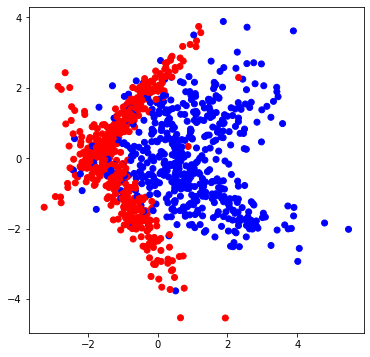

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf = 5):

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

Добавим в логику построения дерева критерии остановки - минимальное количество объектов в листе (min_leaf) и максимальная глубина дерева

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf = 5, max_depth = 5, current_depth = 0, debug = 0):

    quality, t, index = find_best_split(data, labels, min_leaf = min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда 
    #  -- нет прироста в качества 
    #  -- в одной из половин разбитого массива data попадает меньше, чем min_leaf экземпляров
    #  -- текущая глубина дерева равна max_depth
    
    if quality == 0 or current_depth == max_depth:
        if debug: print(f'quality == {quality} index = {index}, t = {t}, len(data[ :index]) = {len(data[ :index])} len(data[index: ]) = {len(data[index: ])} current_depth == {current_depth}') 
        if debug and current_depth == max_depth: print("Достигнута максимальная глубина дерева. Создаем leaf node")
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    current_depth += 1
    true_branch = build_tree(true_data, true_labels, min_leaf = min_leaf, max_depth = max_depth, current_depth = current_depth, debug = 0)
    false_branch = build_tree(false_data, false_labels, min_leaf = min_leaf, max_depth = max_depth, current_depth = current_depth, debug = 0)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def check_branch(n, branch_set = None):
    if not branch_set:
        branch_set = set()
    if isinstance(n, Node) and n.true_branch:
        branch_set.add(id(n.true_branch))
        check_branch(n.true_branch, branch_set)
    if isinstance(n, Node) and n.false_branch:
        branch_set.add(id(n.false_branch))
        check_branch(n.false_branch, branch_set)
    return len(branch_set)

Построим три дерева. Первое с наименьшими ограничениями, второе - ограниченное по глубине по сравнению с первым, третье - ограниченное по минимальному количеству объектов в листе по сравнению с первым.

In [13]:
# Построим дерево по обучающей выборке
my_tree1 = build_tree(train_data, train_labels, min_leaf = 3, max_depth = 10)
my_tree2 = build_tree(train_data, train_labels,  min_leaf = 3, max_depth = 5)
my_tree3 = build_tree(train_data, train_labels,  min_leaf = 50, max_depth = 10)

Проверим количество узлов в каждом дереве:

In [14]:
check_branch(my_tree1), check_branch(my_tree2), check_branch(my_tree3)

(118, 46, 20)

Ограничения действуют. Посмотрим на разделяющие поверхности.

In [15]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [16]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Text(0.5, 1.0, 'Train accuracy')

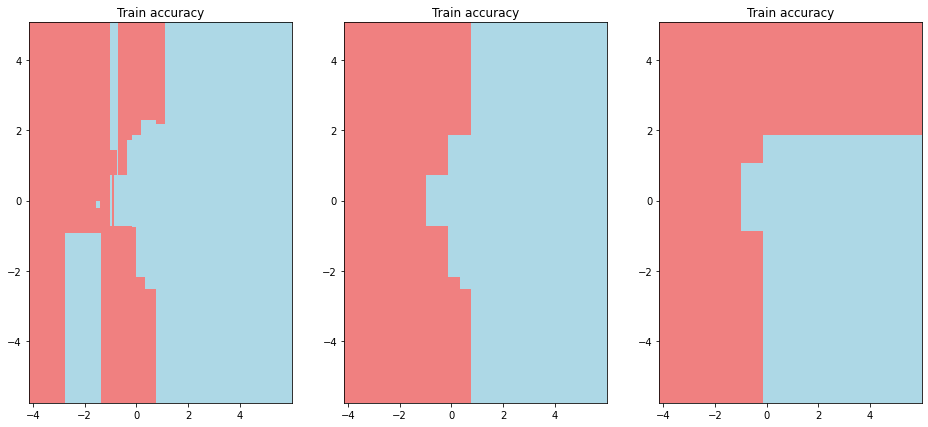

In [17]:
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1, 3, 1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree1)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.title(f'Train accuracy')

plt.subplot(1, 3, 2)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree2)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.title(f'Train accuracy')

plt.subplot(1, 3, 3)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree3)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.title(f'Train accuracy')

Разделяющая поверхность ожидаемо становится менее гранулярной с уменьшением числа узлов в дереве. 